In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

%matplotlib inline

The idea behind a spline interpolation is that we find a polynomial (usually cubic) between each of the points that passes though said points in a smooth manner.  See the figure below.

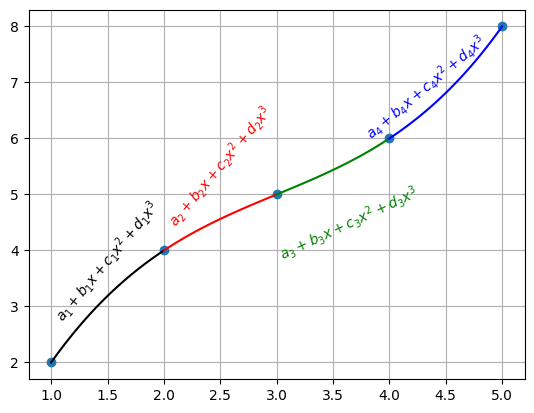

In [2]:
x = [1, 2, 3, 4, 5]
y = [2, 4, 5, 6, 8]

plt.plot(x, y, 'o')

v = CubicSpline(x, y)

u = np.linspace(x[0], x[1], 100)
plt.plot(u, v(u), 'k')
plt.text(1.0, 2.75, '$a_1 + b_1x + c_1x^2 + d_1x^3$', color = 'k', rotation = 50)

u = np.linspace(x[1], x[2], 100)
plt.plot(u, v(u), 'r')
plt.text(2.0, 4.45, '$a_2 + b_2x + c_2x^2 + d_2x^3$', color = 'r', rotation = 50)

u = np.linspace(x[2], x[3], 100)
plt.plot(u, v(u), 'g')
plt.text(3.0, 3.85, '$a_3 + b_3x + c_3x^2 + d_3x^3$', color = 'g', rotation = 25)

u = np.linspace(x[3], x[4], 100)
plt.plot(u, v(u), 'b')
plt.text(3.75, 6.0, '$a_4 + b_4x + c_4x^2 + d_4x^3$', color = 'b', rotation = 40)

plt.grid()

For cubic polynomials, we have four unknowns per equation and for $N$ points, we have $N-1$ different cubics.  Therefore, we have $4(N-1)$ unknowns to determine.  

We know the value of each polynomial segment at each of the node points.  This gives us $2N-2$ equations.  For cubic equations, we insist the first and second derivatives be continuous at each of the internal node points.  This gives us another $2(N-2)$ equations.  We are not two equations short.  We can get these from (somewhat arbitrary) boundary choices.  In this case, we will use the not-a-knot condition and specify that the third derivative is continuous at the second and second-to-last point.  This gives us the same number of equations as unknowns.

##  Continuity of Function

First point
$$d_1(1)^3  + c_1(1)^2 + b_1(1) + a_1 = 2$$

Second point
$$d_1(2)^3 + c_1(2)^2 + b_1(2) + a_1 = 4$$
$$d_2(2)^3 + c_2(2)^3 + b_2(2) + a_2= 4$$


Third point
$$d_2(3)^3 + c_2(3)^2 + b_2(3) + a_2 = 5$$
$$d_3(3)^3 + c_3(3)^2 + b_3(3) + a_3 = 5$$

Fourth point
$$d_3(4)^3 + c_3(4)^2 + b_3(4) + a_3= 6$$
$$d_4(4)^3 + c_4(4)^2 + b_4(4) + a_4= 6$$


Fifth point
$$d_4(5)^3 + c_4(5)^2 + b_4(5) + a_4 = 8$$

##  Continuity of Derivatives

Second Point - First to Second Polynomial Continuity
$$b_1 + 2c_1(2) + 3d_1(2)^2 - b_2 - 2c_2(2) - 3d_2(2)^2 = 0$$
$$  2c_1 + 6d_1(2) - 2c_2 - 6d_2(2) = 0$$

Third Point - Second to Third Polynomial Continuity
$$3d_2(3)^2 + 2c_2(3) + b_2 - 3d_3(3)^2 - 2c_3(3) -b_3 = 0$$
$$6d_2(3) +2c_2 - 6d_3(3) -2c_2= 0$$

Fourth Point - Third to Fourth Polynomial Continuity
$$3d_3(4)^2  + 2c_3(4) + b_3 - 3d_4(4)^2 - 2c_4(4) - b_4 = 0$$
$$6d_3(4) 2c_3 - 6d_4(4) -2c_4 = 0$$

##  Not-a-knot Condition

$$6d_4 - 6d_5 = 0$$
$$6d_1 - 6d_2 = 0$$

Now that we have our system of equations, all that remains is to solve it.  This is a simple linear algebra problem.  Alothough the matrix is sparse, I am not going to bother with that and instead use a dense matrix.  Obviously, for code in the real world, you'd probably try to take advatage of the sparcity.

This is how I will organize the vector of unknowns.
$$
\begin{pmatrix}
d_1 \\
c_1 \\
b_1 \\
a_1 \\
d_2 \\
c_2 \\
b_2 \\
a_2 \\
d_3 \\
c_3 \\
b_3 \\
a_3 \\
d_4 \\
c_4 \\
b_4 \\
a_4
\end{pmatrix}
$$

Each of the equations above will be represented by a row vector, then stacked into a single matrix equation.

In [3]:
#  Row 0 - left-hand side
row0 = np.zeros(16)
row0[0:4] = np.array([1,1,1,1])

#  Row 1 - first boundary continuity, first equation
row1 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([2**3, 2**2, 2**1, 2**0])
row1[0:4] = temp

#  Row 2 - first boundary continuity, second equation
row2 = np.zeros(16)
row2[4:8] = temp

#  Row 3 - first boundary first derivative
row3 = np.zeros(16)
temp = np.array([3, 2, 1, 0]) * np.array([2**2, 2**1, 2**0, 0])
row3[0:4] = temp
row3[4:8] = -temp

#  Row 4 - first boundary second derivative
row4 = np.zeros(16)
temp = np.array([6, 2, 0, 0]) * np.array([2**1, 2**0, 0, 0])
row4[0:4] = temp
row4[4:8] = -temp

#  Row 5 - First boundary, third derivative
row5 = np.zeros(16)
row5[0] = 1
row5[4] = -1

#  Row 6 - second boundary continity
row6 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([3**3, 3**2, 3**1, 3**0])
row6[4:8] = temp

#  Row 7 - Second boundary continuity
row7 = np.zeros(16)
row7[8:12] = temp

#  Row 8 - Second boundary first derivative
row8 = np.zeros(16)
temp = np.array([3, 2, 1, 0]) * np.array([3**2, 3**1, 3**0, 0])
row8[4:8] = temp
row8[8:12] = -temp

#  Row 9 - Second boundary second derivative
row9 = np.zeros(16)
temp = np.array([6, 2, 0, 0]) * np.array([3**1, 3**0, 0, 0])
row9[4:8] = temp
row9[8:12] = -temp

#  Row 10 - Third boundary, continuity
row10 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([4**3, 4**2, 4**1, 4**0])
row10[8:12] = temp

#  Row 11 - Third boundary, continuity
row11 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([4**3, 4**2, 4**1, 4**0])
row11[12:] = temp

#  Row 12 - Thirday boundary, first derivative
row12 = np.zeros(16)
temp = np.array([3, 2, 1, 0]) * np.array([4**2, 4**1, 4**0, 0])
row12[8:12] = temp
row12[12:] = -temp

#  Row 13 - Third boundary second derivative
row13 = np.zeros(16)
temp = np.array([6, 2, 0, 0]) * np.array([4**1, 4**0, 0, 0])
row13[8:12] = temp
row13[12:] = -temp

#  Row 14 - Third boundary third derivative
row14 = np.zeros(16)
row14[8] = 1
row14[12] = -1

#  Row 15 - Third boundary, continuity
row15 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([5**3, 5**2, 5**1, 5**0])
row15[12:] = temp

Putting everything together we have,
$$
\left(
\begin{array}{cccccccccccccccc}
1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
8 & 4 & 2 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 8 & 4 & 2 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
12& 4 & 1 & 0 &-12&-4 &-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
12& 2 & 0 & 0 &-12&-2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 &-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 27& 9 & 3 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 27& 9 & 3 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 27& 6 & 1 & 0 &-27&-6 & -1& 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 18& 2 & 0 & 0 &-18&-2 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 64& 16& 4 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 64& 16& 4 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 48& 8 & 1 & 0 &-48& -8& -1& 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 24& 2 & 0 & 0 &-24& -2& 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & -1& 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &125& 25& 5 & 1
\end{array}\right)
\begin{pmatrix}
d_1 \\
c_1 \\
b_1 \\
a_1 \\
d_2 \\
c_2 \\
b_2 \\
a_2 \\
d_3 \\
c_3 \\
b_3 \\
a_3 \\
d_4 \\
c_4 \\
b_4 \\
a_4
\end{pmatrix}
=
\begin{pmatrix}
2 \\
4 \\
4 \\
0 \\
0 \\
0 \\
5 \\
5 \\
0 \\
0 \\
6 \\
6 \\
0 \\
0 \\
0 \\
8
\end{pmatrix}.
$$

Again, this is a sparse matrix, but in the code below, we are not taking advantage of that.

In [4]:
#  Create square matrix
A = np.vstack( (row0, row1, row2, row3, row4, row5,
               row6, row7, row8, row9, row10, row11,
               row12, row13, row14, row15))

print(A)

#  This is our vector of knowns.
b = np.array([2, 4, 4, 0, 0, 0, 5, 5, 0, 0, 6, 6, 0, 0, 0, 8])

# Solve the system and print out the result
w = np.linalg.solve(A, b)
print(w)

[[  1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  8.   4.   2.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   8.   4.   2.   1.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [ 12.   4.   1.   0. -12.  -4.  -1.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [ 12.   2.   0.   0. -12.  -2.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  1.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.  27.   9.   3.   1.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  27.   9.   3.   1.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.  27.   6.   1.   0. -27.  -6.  -1.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.  18.   2.   0.   0. -18.  -2.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  64.  16.   4.   1.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64

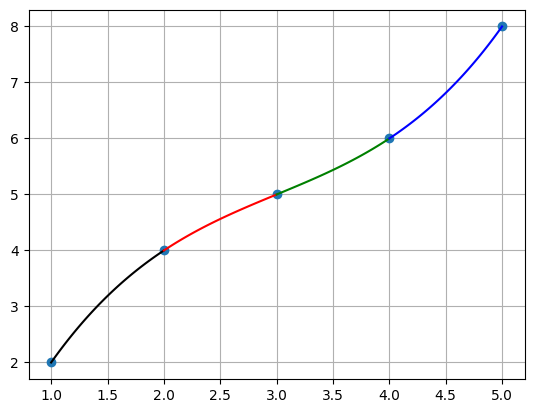

In [5]:
#  Can we generate the above plot using our spline values?
plt.plot(x, y, 'o')
plt.grid()

u = np.linspace(1, 2)
plt.plot(u, np.polyval(w[0:4], u), 'k')

u = np.linspace(2, 3)
plt.plot(u, np.polyval(w[4:8], u), 'r')

u = np.linspace(3, 4)
plt.plot(u, np.polyval(w[8:12], u), 'g')

u = np.linspace(4, 5)
plt.plot(u, np.polyval(w[12:], u), 'b')

In practice, splines are usually calculated using the form,
$$d(x-x_i)^3 + c(x-x_i)^2 + b(x-x_1) + a$$
on the interval between $x_i$ and $x_{i+1}$

For our points above, the equations would be,

$$\text{Interval 1:} \quad d_1(x-1)^3 + c_1(x-1)^2 + b_1(x-1) + a_1$$
$$\text{Interval 2:} \quad d_2(x-2)^3 + c_2(x-2)^2 + b_2(x-2) + a_2$$
$$\text{Interval 3:} \quad d_3(x-3)^3 + c_3(x-3)^2 + b_3(x-3) + a_3$$
$$\text{Interval 4:} \quad d_4(x-4)^3 + c_4(x-4)^2 + b_4(x-4) + a_4$$

Let's rebuild our system of equations using this form and compare our coefficients with that from Scipy's CubicSpline function.

In [8]:
#  Row 0
row0 = np.zeros(16)
row0[0:4] = np.array([0,0,0,1])

#  Row 1 - first boundary continuity
row1 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(2-1)**3, (2-1)**2, (2-1)**1, (2-1)**0])
row1[0:4] = temp

#  Row 2 - first boundary continuity
row2 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(2-2)**3, (2-2)**2, (2-2)**1, 1])
row2[4:8] = temp

#  Row 3 - first boundary first derivative
row3 = np.zeros(16)
temp = np.array([3, 2, 1, 0]) * np.array([(2-1)**2, (2-1)**1, 1, 0])
row3[0:4] = temp
temp = np.array([3, 2, 1, 0]) * np.array([(2-2)**2, (2-2)**1, 1, 0])
row3[4:8] = -temp

#  Row 4 - first boundary second derivative
row4 = np.zeros(16)
temp = np.array([6, 2, 0, 0]) * np.array([(2-1)**1, 1, 0, 0])
row4[0:4] = temp
temp = np.array([6, 2, 0, 0]) * np.array([(2-2)**1, 1, 0, 0])
row4[4:8] = -temp

#  Row 5 - First boundary, third derivative
row5 = np.zeros(16)
row5[0] = 1
row5[4] = -1

#  Row 6 - second boundary continity
row6 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(3-2)**3, (3-2)**2, (3-2)**1, (3-2)**0])
row6[4:8] = temp

#  Row 7 - Second boundary continuity
row7 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(3-3)**3, (3-3)**2, (3-3)**1, 1])
row7[8:12] = temp

#  Row 8 - Second boundary first derivative
row8 = np.zeros(16)
temp = np.array([3, 2, 1, 0]) * np.array([(3-2)**2, (3-2)**1, (3-2)**0, 0])
row8[4:8] = temp
temp = np.array([3, 2, 1, 0]) * np.array([(3-3)**2, (3-3)**1, 1, 0])
row8[8:12] = -temp

#  Row 9 - Second boundary second derivative
row9 = np.zeros(16)
temp = np.array([6, 2, 0, 0]) * np.array([(3-2)**1, (3-2)**0, 0, 0])
row9[4:8] = temp
temp = np.array([6, 2, 0, 0]) * np.array([(3-3)**1, 1, 0, 0])
row9[8:12] = -temp

#  Row 10 - Third boundary, continuity
row10 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(4-3)**3, (4-3)**2, (4-3)**1, (4-3)**0])
row10[8:12] = temp

#  Row 11 - Third boundary, continuity
row11 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(4-4)**3, (4-4)**2, (4-4)**1, 1])
row11[12:] = temp

#  Row 12 - Thirday boundary, first derivative
row12 = np.zeros(16)
temp = np.array([3, 2, 1, 0]) * np.array([(4-3)**2, (4-3)**1, (4-3)**0, 0])
row12[8:12] = temp
temp = np.array([3, 2, 1, 0]) * np.array([(4-4)**2, (4-4)**1, 1, 0])
row12[12:] = -temp

#  Row 13 - Third boundary second derivative
row13 = np.zeros(16)
temp = np.array([6, 2, 0, 0]) * np.array([(4-3)**1, (4-3)**0, 0, 0])
row13[8:12] = temp
temp = np.array([6, 2, 0, 0]) * np.array([(4-4)**1, 1, 0, 0])
row13[12:] = -temp

#  Row 14 - Third boundary third derivative
row14 = np.zeros(16)
row14[8] = 1
row14[12] = -1

#  Row 15 - Third boundary, continuity
row15 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(5-4)**3, (5-4)**2, (5-4)**1, (5-4)**0])
row15[12:] = temp

A = np.vstack( (row0, row1, row2, row3, row4, row5,
               row6, row7, row8, row9, row10, row11,
               row12, row13, row14, row15))

print(A)

#plt.spy(A)
b = np.array([2, 4, 4, 0, 0, 0, 5, 5, 0, 0, 6, 6, 0, 0, 0, 8])

w = np.linalg.solve(A, b)
print(w)

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 3.  2.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 6.  2.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  3.  2.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6.  2.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  2.  1.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  6.  2.  0.  0.  0. -2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0. 

In [9]:
print('First interval, our code', w[0:4])
print('First interval, CubicSpline', v.c[:,0])
print()
print('Second interval, our code', w[4:8])
print('Second interval, CubicSpline', v.c[:,1])
print()
print('Third interval, our code', w[8:12])
print('Third interval, CubicSpline', v.c[:,2])
print()
print('Fourth interval, our code', w[12:])
print('Fourth interval, CubicSpline', v.c[:,3])

First interval, our code [ 0.16666667 -1.          2.83333333  2.        ]
First interval, CubicSpline [ 0.16666667 -1.          2.83333333  2.        ]

Second interval, our code [ 0.16666667 -0.5         1.33333333  4.        ]
Second interval, CubicSpline [ 0.16666667 -0.5         1.33333333  4.        ]

Third interval, our code [ 1.66666667e-01 -6.66133815e-16  8.33333333e-01  5.00000000e+00]
Third interval, CubicSpline [1.66666667e-01 5.55111512e-16 8.33333333e-01 5.00000000e+00]

Fourth interval, our code [0.16666667 0.5        1.33333333 6.        ]
Fourth interval, CubicSpline [0.16666667 0.5        1.33333333 6.        ]


##  Natural Boundary Conditions

Now, we will reimplement the cubic spline example with a natural boundary conditions instead of a not-a-knot
$$f_{1}''(x_1) = 0$$
$$f_{n}''(x_n) = 0$$

Therefore, the natural boundary condition can be implemented as:
$$ 2c_1 + 6d_1(1-1) = 0$$
$$ 2c_4 + 6d_4(5-4) = 0$$

In [15]:
# Column Number: 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15
# Column Label: d1, c1, b1, a1, d2, c2, b2, a2, d3, c3, b3, a3, d4, c4, b4, a4

#  Row 0
row0 = np.zeros(16)
row0[0:4] = np.array([0,0,0,1])

#  Row 1 - first boundary continuity
row1 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(2-1)**3, (2-1)**2, (2-1)**1, (2-1)**0])
row1[0:4] = temp

#  Row 2 - first boundary continuity
row2 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(2-2)**3, (2-2)**2, (2-2)**1, 1])
row2[4:8] = temp

#  Row 3 - first boundary first derivative
row3 = np.zeros(16)
temp = np.array([3, 2, 1, 0]) * np.array([(2-1)**2, (2-1)**1, 1, 0])
row3[0:4] = temp
temp = np.array([3, 2, 1, 0]) * np.array([(2-2)**2, (2-2)**1, 1, 0])
row3[4:8] = -temp

#  Row 4 - first boundary second derivative
row4 = np.zeros(16)
temp = np.array([6, 2, 0, 0]) * np.array([(2-1)**1, 1, 0, 0])
row4[0:4] = temp
temp = np.array([6, 2, 0, 0]) * np.array([(2-2)**1, 1, 0, 0])
row4[4:8] = -temp

#  Row 5 - First natural boundary condition, second derivative
row5 = np.zeros(16)
row5[0] = 6 * (1-1)
row5[1] = 2

#  Row 6 - second boundary continity
row6 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(3-2)**3, (3-2)**2, (3-2)**1, (3-2)**0])
row6[4:8] = temp

#  Row 7 - Second boundary continuity
row7 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(3-3)**3, (3-3)**2, (3-3)**1, 1])
row7[8:12] = temp

#  Row 8 - Second boundary first derivative
row8 = np.zeros(16)
temp = np.array([3, 2, 1, 0]) * np.array([(3-2)**2, (3-2)**1, (3-2)**0, 0])
row8[4:8] = temp
temp = np.array([3, 2, 1, 0]) * np.array([(3-3)**2, (3-3)**1, 1, 0])
row8[8:12] = -temp

#  Row 9 - Second boundary second derivative
row9 = np.zeros(16)
temp = np.array([6, 2, 0, 0]) * np.array([(3-2)**1, (3-2)**0, 0, 0])
row9[4:8] = temp
temp = np.array([6, 2, 0, 0]) * np.array([(3-3)**1, 1, 0, 0])
row9[8:12] = -temp

#  Row 10 - Third boundary, continuity
row10 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(4-3)**3, (4-3)**2, (4-3)**1, (4-3)**0])
row10[8:12] = temp

#  Row 11 - Third boundary, continuity
row11 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(4-4)**3, (4-4)**2, (4-4)**1, 1])
row11[12:] = temp

#  Row 12 - Third boundary, first derivative
row12 = np.zeros(16)
temp = np.array([3, 2, 1, 0]) * np.array([(4-3)**2, (4-3)**1, (4-3)**0, 0])
row12[8:12] = temp
temp = np.array([3, 2, 1, 0]) * np.array([(4-4)**2, (4-4)**1, 1, 0])
row12[12:] = -temp

#  Row 13 - Third boundary second derivative
row13 = np.zeros(16)
temp = np.array([6, 2, 0, 0]) * np.array([(4-3)**1, (4-3)**0, 0, 0])
row13[8:12] = temp
temp = np.array([6, 2, 0, 0]) * np.array([(4-4)**1, 1, 0, 0])
row13[12:] = -temp

#  Row 14 - Third natural boundary condition, second derivative
row14 = np.zeros(16)
row14[12] = 6 * (5-4)
row14[13] = 2

#  Row 15 - Third boundary, continuity
row15 = np.zeros(16)
temp = np.array([1,1,1,1]) *  np.array([(5-4)**3, (5-4)**2, (5-4)**1, (5-4)**0])
row15[12:] = temp

b = np.array([2, 4, 4, 0, 0, 0, 5, 5, 0, 0, 6, 6, 0, 0, 0, 8])

A = np.vstack( (row0, row1, row2, row3, row4, row5,
               row6, row7, row8, row9, row10, row11,
               row12, row13, row14, row15))

print(A)

#plt.spy(A)

w = np.linalg.solve(A, b)
print(w)

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 3.  2.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 6.  2.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  3.  2.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6.  2.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  2.  1.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  6.  2.  0.  0.  0. -2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  2.  0. 

In [16]:
x = [1, 2, 3, 4, 5]
y = [2, 4, 5, 6, 8]

v = CubicSpline(x, y, bc_type='natural')

print('First interval, our code', w[0:4])
print('First interval, CubicSpline', v.c[:,0])
print()
print('Second interval, our code', w[4:8])
print('Second interval, CubicSpline', v.c[:,1])
print()
print('Third interval, our code', w[8:12])
print('Third interval, CubicSpline', v.c[:,2])
print()
print('Fourth interval, our code', w[12:])
print('Fourth interval, CubicSpline', v.c[:,3])

First interval, our code [-0.25  0.    2.25  2.  ]
First interval, CubicSpline [-0.25  0.    2.25  2.  ]

Second interval, our code [ 0.25 -0.75  1.5   4.  ]
Second interval, CubicSpline [ 0.25 -0.75  1.5   4.  ]

Third interval, our code [0.25 0.   0.75 5.  ]
Third interval, CubicSpline [2.50000000e-01 1.11022302e-16 7.50000000e-01 5.00000000e+00]

Fourth interval, our code [-0.25  0.75  1.5   6.  ]
Fourth interval, CubicSpline [-0.25  0.75  1.5   6.  ]
